### Walktimes to Adult Education Upgrading

## Introduction
In this tutorial we will analyse walk times from address points within the City of Toronto to the Toronto Transit Commission (TTC) Stops. ESCs can include subway, LRT, street car and bus. The analysis will use Panada to perform the network calculation. The results will be displayed City wide and at the level of an individual City of Toronto Neighbourhood Improvement Area. Neighbourhood Improvement Areas have been chosen as one of the domains used to determine them is the physical surroundings including access to transportation.

The analysis will use data from the City of Toronto's Open Data site including AEUs (https://open.toronto.ca/dataset/ttc-routes-and-schedules/), the City of Toronto's pedestrian network (https://open.toronto.ca/dataset/pedestrian-network/), Toronto One Address Repository address point data (https://open.toronto.ca/dataset/address-points-municipal-toronto-one-address-repository/) and Neighbourhood Improvement Areas (https://open.toronto.ca/dataset/neighbourhood-improvement-areas/).

The TTC Routes and Schedules zip file contains route definitions, stop patterns, stop locations, and schedules. For this tutorial we will be using the stops.txt file.

The City of Toronto pedestrian network was a collective effort by the City of Toronto's Information and Technology Division's Data Analytics and Visualization team (DAV) and the City of Toronto's Transportation Services Division. A pedestrian network based on sidewalk centerlines and pedestrian-assets (e.g., sidewalks, crosswalks, pedestrian controlled crossings) was created with the focus being placed on the topological consistency over spatial accuracy. Meaning that the sidewalk centerlines are not necessarily spatially located along with the actual locations of the sidewalk geographically, but the connections between different sidewalk segments were maintained as being a higher priority.

The City of Toronto address point data contains over 500,000 address points within the city. A readme file is also included which explains the each of the attributes.

Neighbourhood Improvement Areas are specially-selected and designated neighbourhoods in the City of Toronto found to have inequities on several indicators of well-being. Currently 31 out of 140 neighbourhoods are designated as NIAs as part of the Toronto Strong Neighbourhoods 2020 (TSNS2020) project. Please see the link for further information (https://www.toronto.ca/city-government/data-research-maps/research-reports/social-reports/toronto-strong-neighbourhoods-strategy-2020/).

In [1]:
!pip install geopandas

In [2]:
!pip install psycopg2


In [3]:
!pip install pandana

In [4]:
!pip install basemap --user

In [5]:
!pip install geoalchemy2

In [6]:
!pip install mapclassify

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandana as pdna
import networkx as nx
from shapely.geometry import LineString
%matplotlib inline

## Step 1: Importing and Cleaning Data
### Importing Data
We can read the AEU (Adult Education Upgrading) text file and create geometry using the latitude longitude columns supplied in the data. We can use the geopandas.read_file function to read the pednet, address and Neighbourhood Improvement Areas ESRI shape files and reproject them to EPSG 2019. Please see the link for the description of EPSG 2019 (https://epsg.io/2019).

### Read AEU Data
Read the AEU data text file and create the spatial layer using the latitude and longitude provided in the file. The layer will be reprojected to EPSG 2019.

In [8]:
AEU_dataset = pd.read_csv('Adult Education Upgrading - 4326.csv', delimiter= ',')

AEU_dataset

,_id,OBJECTID,AGENCY_NAME,ORGANIZATION_ADDRESS,NEIGHBOURHOOD,OFFICE_PHONE,EMAIL,WEBSITE,ELIGIBILITY,DESCRIPTION_SERVICE,...,DATE_UPDATED,ADDRESS_POINT_ID,X,Y,LONGITUDE,LATITUDE,ADDRESS_FULL,MUNICIPALITY,POSTAL_CODE,geometry
0,1,75,Centre for Community Learning & Development,"Parliament Street Library, 269 Gerrard St E, 2...","Moss Park, 73",416-968-6989 ext 104,admin@tccld.org,"<a href=""http://www.tccld.org"" target=""_blank""...",English-speaking adults * varies by program,"Adult education, training and development * co...",...,2015-06-04T04:00:00,4014968,NaN,NaN,NaN,NaN,269 Gerrard St E,former Toronto,M5A 2G3,"{'type': 'Point', 'coordinates': (-79.36795468..."
1,2,76,Independent Learning Centre,"TVO, 2180 Yonge St, Ground Fl, Toronto, ON ...","Yonge-Eglinton, 100",English 416-484-2704 ; French 416-484-2722,ilc@tvo.org,"<a href=""http://www.ilc.org"" target=""_blank"">w...",NaN,"Secondary school, online distance education co...",...,2015-02-05T05:00:00,11272587,NaN,NaN,NaN,NaN,2180 Yonge St,former Toronto,M4S 2B9,"{'type': 'Point', 'coordinates': (-79.39824713..."
2,3,77,PTP -- Adult Learning and Employment Programs,"5415 Dundas St W, Ste 200, Toronto, ON M9B...","Islington-City Centre West, 14",416-239-7309,barbm@ptp.ca,"<a href=""http://www.ptp.ca"" target=""_blank"">ww...",Unemployed men and women 19 years and older,"Adult upgrading, employment planning and job s...",...,2015-08-28T04:00:00,8087266,NaN,NaN,NaN,NaN,5415 Dundas St W,Etobicoke,M9B 1B5,"{'type': 'Point', 'coordinates': (-79.54129019..."
3,4,78,YWCA Toronto,"3090 Kingston Rd, 3rd Fl, Toronto, ON M1M 1P2","Cliffcrest, 123",416-269-0090,ywcatrainingcentre@ywcatoronto.org,"<a href=""http://www.ywcatoronto.org"" target=""_...",Open to all women,"Individualized training, job coaching, compute...",...,2014-07-25T04:00:00,4228722,NaN,NaN,NaN,NaN,3090 Kingston Rd,Scarborough,M1M 1P2,"{'type': 'Point', 'coordinates': (-79.23154803..."
4,5,79,Seneca College,"1 York Gate Blvd, 2nd Fl, Toronto, ON M3N 3A1","Black Creek, 24",416-491-5050 ext 44746,bebena.demian@senecacollege.ca,"<a href=""http://www.senecacollege.ca"" target=""...","Ontario residents 19 years and older, with lit...",<b>Literacy and Basic Skills</b><br>\nLiteracy...,...,2015-10-16T04:00:00,11297202,NaN,NaN,NaN,NaN,1 York Gate Blvd,North York,M3N 3A1,"{'type': 'Point', 'coordinates': (-79.51943934..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,74,257,Toronto District School Board,Burnhamthorpe Collegiate Adult Learning Centre...,"Dovercourt-Wallace Emerson-Junction, 93",416-394-3809,upgrading@tdsb.on.ca,"<a href=""http://www.upgrademyskills.ca"" target...","Ontario residents 19 years and older, with lit...",<b>Literacy and Basic Skills</b><br>\nLiteracy...,...,2015-02-09T05:00:00,6765660,NaN,NaN,NaN,NaN,500 The East Mall,Etobicoke,M9B 2C4,"{'type': 'Point', 'coordinates': (-79.56183840..."
74,75,258,Centennial College,"Ashtonbee Campus, 75 Ashtonbee Rd, Toronto, ON...","Wexford-Maryvale, 119",416-289-5000 ext 7022,jboatswain@centennialcollege.ca,"<a href=""http://www.centennialcollege.ca/advan...",Adults 19 years and older,"Basic academic upgrading for college entrance,...",...,2016-02-18T05:00:00,11048263,NaN,NaN,NaN,NaN,75 Ashtonbee Rd,Scarborough,M1L 4N4,"{'type': 'Point', 'coordinates': (-79.28978672..."
75,76,259,Learning Enrichment Foundation,"116 Industry St, Toronto, ON M6M 4L8","Beechborough-Greenbrook, 112",416-769-0830,pamelagr@lefca.org,"<a href=""http://www.lefca.org"" target=""_blank""...","Landed immigrants, Convention refugees or Perm...",Participates in LINC (Language Instruction for...,...,2015-02-02T05:00:00,14072410,NaN,NaN,NaN,NaN,116 Industry St,North York,M6M 4L8,"{'type': 'Point', 'coordinates': (-79.49309152..."
76,77,260,George Brown College,"St James Campus, 200 King St E, Rm 581C, Toron...","Moss Park, 73",416-415-5000 ext 2958,dbradley@georgebrown.ca,"<a href=""http://www.georgebrown.ca/deafupgradi...",Deaf and/or hard of hearing us

In [9]:
# Let's check out the .shp file instead (same dataset)

AEU_dataset = gpd.read_file('Adult Education Upgrading.shp', delimiter= ',')
AEU_dataset.head()

,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,FIELD_10,...,FIELD_16,FIELD_17,FIELD_18,FIELD_19,FIELD_20,FIELD_21,FIELD_22,FIELD_23,FIELD_24,geometry
0,1,75,Centre for Community Learning & Development,"Parliament Street Library, 269 Gerrard St E, 2...","Moss Park, 73",416-968-6989 ext 104,admin@tccld.org,"<a href=""http://www.tccld.org"" target=""_blank""...",English-speaking adults * varies by program,"Adult education, training and development * co...",...,2015-06-04T04:00:00,4014968,None,None,None,None,269 Gerrard St E,former Toronto,M5A 2G3,POINT (-79.36795 43.66183)
1,2,76,Independent Learning Centre,"TVO, 2180 Yonge St, Ground Fl, Toronto, ON ...","Yonge-Eglinton, 100",English 416-484-2704 ; French 416-484-2722,ilc@tvo.org,"<a href=""http://www.ilc.org"" target=""_blank"">w...",None,"Secondary school, online distance education co...",...,2015-02-05T05:00:00,11272587,None,None,None,None,2180 Yonge St,former Toronto,M4S 2B9,POINT (-79.39825 43.70464)
2,3,77,PTP -- Adult Learning and Employment Programs,"5415 Dundas St W, Ste 200, Toronto, ON M9B...","Islington-City Centre West, 14",416-239-7309,barbm@ptp.ca,"<a href=""http://www.ptp.ca"" target=""_blank"">ww...",Unemployed men and women 19 years and older,"Adult upgrading, employment planning and job s...",...,2015-08-28T04:00:00,8087266,None,None,None,None,5415 Dundas St W,Etobicoke,M9B 1B5,POINT (-79.54129 43.63396)
3,4,78,YWCA Toronto,"3090 Kingston Rd, 3rd Fl, Toronto, ON M1M 1P2","Cliffcrest, 123",416-269-0090,ywcatrainingcentre@ywcatoronto.org,"<a href=""http://www.ywcatoronto.org"" target=""_...",Open to all women,"Individualized training, job coaching, compute...",...,2014-07-25T04:00:00,4228722,None,None,None,None,3090 Kingston Rd,Scarborough,M1M 1P2,POINT (-79.23155 43.72631)
4,5,79,Seneca College,"1 York Gate Blvd, 2nd Fl, Toronto, ON M3N 3A1","Black Creek, 24",416-491-5050 ext 44746,bebena.demian@senecacollege.ca,"<a href=""http://www.senecacollege.ca"" target=""...","Ontario residents 19 years and older, with lit...",<b>Literacy and Basic Skills</b><br>\nLiteracy...,...,2015-10-16T04:00:00,11297202,None,None,None,None,1 York Gate Blvd,North York,M3N 3A1,POINT (-79.51944 43.75850)


In [10]:
AEU_dataset.columns

Index(['FIELD_1', 'FIELD_2', 'FIELD_3', 'FIELD_4', 'FIELD_5', 'FIELD_6',
       'FIELD_7', 'FIELD_8', 'FIELD_9', 'FIELD_10', 'FIELD_11', 'FIELD_12',
       'FIELD_13', 'FIELD_14', 'FIELD_15', 'FIELD_16', 'FIELD_17', 'FIELD_18',
       'FIELD_19', 'FIELD_20', 'FIELD_21', 'FIELD_22', 'FIELD_23', 'FIELD_24',
       'geometry'],
      dtype='object')

In [1]:
#replacing column fields with their respective names

In [11]:
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_1', '_id')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_2', 'OBJECTID')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_3', 'AGENCY_NAME')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_4', 'ORGANIZATION_ADDRESS')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_5', 'NEIGHBOURHOOD')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_6', 'OFFICE_PHONE')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_7', 'EMAIL')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_8', 'WEBSITE')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_9', 'ELIGIBILITY')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_10', 'DESCRIPTION_SERVICE')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_11', 'APPLICATION')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_12', 'LANGUAGES')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_13', 'ACCESSIBILITY')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_14', 'HOURS')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_15', 'LEGAL_STATUS')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_16', 'DATE_UPDATED')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_17', 'ADDRESS_POINT_ID')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_18', 'X')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_19', 'Y')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_20', 'LONGITUDE')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_21', 'LATITUDE')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_22', 'ADDRESS_FULL')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_23', 'MUNICIPALITY')
AEU_dataset.columns = AEU_dataset.columns.str.replace('FIELD_24', 'POSTAL_CODE')



In [12]:
AEU_dataset.columns

Index(['_id', 'OBJECTID', 'AGENCY_NAME', 'ORGANIZATION_ADDRESS',
       'NEIGHBOURHOOD', 'OFFICE_PHONE', 'EMAIL', 'WEBSITE', 'ELIGIBILITY',
       '_id0', '_id1', '_id2', '_id3', '_id4', '_id5', '_id6', '_id7', '_id8',
       '_id9', 'OBJECTID0', 'OBJECTID1', 'OBJECTID2', 'OBJECTID3', 'OBJECTID4',
       'geometry'],
      dtype='object')

In [13]:
AEU_dataset.columns = AEU_dataset.columns.str.replace('_id0','DESCRIPTION_SERVICE')
AEU_dataset.columns = AEU_dataset.columns.str.replace('_id1', 'APPLICATION')
AEU_dataset.columns = AEU_dataset.columns.str.replace('_id2', 'LANGUAGES')
AEU_dataset.columns = AEU_dataset.columns.str.replace('_id3', 'ACCESSIBILITY')
AEU_dataset.columns = AEU_dataset.columns.str.replace('_id4', 'HOURS')
AEU_dataset.columns = AEU_dataset.columns.str.replace('_id5', 'LEGAL_STATUS')
AEU_dataset.columns = AEU_dataset.columns.str.replace('_id6', 'DATE_UPDATED')
AEU_dataset.columns = AEU_dataset.columns.str.replace('_id7', 'ADDRESS_POINT_ID')
AEU_dataset.columns = AEU_dataset.columns.str.replace('_id8', 'X')
AEU_dataset.columns = AEU_dataset.columns.str.replace('_id9', 'Y')
AEU_dataset.columns = AEU_dataset.columns.str.replace('OBJECTID0', 'LONGITUDE')
AEU_dataset.columns = AEU_dataset.columns.str.replace('OBJECTID1', 'LATITUDE')
AEU_dataset.columns = AEU_dataset.columns.str.replace('OBJECTID2', 'ADDRESS_FULL')
AEU_dataset.columns = AEU_dataset.columns.str.replace('OBJECTID3', 'MUNICIPALITY')
AEU_dataset.columns = AEU_dataset.columns.str.replace('OBJECTID4', 'POSTAL_CODE')


In [14]:
AEU_dataset.columns

Index(['_id', 'OBJECTID', 'AGENCY_NAME', 'ORGANIZATION_ADDRESS',
       'NEIGHBOURHOOD', 'OFFICE_PHONE', 'EMAIL', 'WEBSITE', 'ELIGIBILITY',
       'DESCRIPTION_SERVICE', 'APPLICATION', 'LANGUAGES', 'ACCESSIBILITY',
       'HOURS', 'LEGAL_STATUS', 'DATE_UPDATED', 'ADDRESS_POINT_ID', 'X', 'Y',
       'LONGITUDE', 'LATITUDE', 'ADDRESS_FULL', 'MUNICIPALITY', 'POSTAL_CODE',
       'geometry'],
      dtype='object')

In [15]:
AEU_dataset.head()

,_id,OBJECTID,AGENCY_NAME,ORGANIZATION_ADDRESS,NEIGHBOURHOOD,OFFICE_PHONE,EMAIL,WEBSITE,ELIGIBILITY,DESCRIPTION_SERVICE,...,DATE_UPDATED,ADDRESS_POINT_ID,X,Y,LONGITUDE,LATITUDE,ADDRESS_FULL,MUNICIPALITY,POSTAL_CODE,geometry
0,1,75,Centre for Community Learning & Development,"Parliament Street Library, 269 Gerrard St E, 2...","Moss Park, 73",416-968-6989 ext 104,admin@tccld.org,"<a href=""http://www.tccld.org"" target=""_blank""...",English-speaking adults * varies by program,"Adult education, training and development * co...",...,2015-06-04T04:00:00,4014968,None,None,None,None,269 Gerrard St E,former Toronto,M5A 2G3,POINT (-79.36795 43.66183)
1,2,76,Independent Learning Centre,"TVO, 2180 Yonge St, Ground Fl, Toronto, ON ...","Yonge-Eglinton, 100",English 416-484-2704 ; French 416-484-2722,ilc@tvo.org,"<a href=""http://www.ilc.org"" target=""_blank"">w...",None,"Secondary school, online distance education co...",...,2015-02-05T05:00:00,11272587,None,None,None,None,2180 Yonge St,former Toronto,M4S 2B9,POINT (-79.39825 43.70464)
2,3,77,PTP -- Adult Learning and Employment Programs,"5415 Dundas St W, Ste 200, Toronto, ON M9B...","Islington-City Centre West, 14",416-239-7309,barbm@ptp.ca,"<a href=""http://www.ptp.ca"" target=""_blank"">ww...",Unemployed men and women 19 years and older,"Adult upgrading, employment planning and job s...",...,2015-08-28T04:00:00,8087266,None,None,None,None,5415 Dundas St W,Etobicoke,M9B 1B5,POINT (-79.54129 43.63396)
3,4,78,YWCA Toronto,"3090 Kingston Rd, 3rd Fl, Toronto, ON M1M 1P2","Cliffcrest, 123",416-269-0090,ywcatrainingcentre@ywcatoronto.org,"<a href=""http://www.ywcatoronto.org"" target=""_...",Open to all women,"Individualized training, job coaching, compute...",...,2014-07-25T04:00:00,4228722,None,None,None,None,3090 Kingston Rd,Scarborough,M1M 1P2,POINT (-79.23155 43.72631)
4,5,79,Seneca College,"1 York Gate Blvd, 2nd Fl, Toronto, ON M3N 3A1","Black Creek, 24",416-491-5050 ext 44746,bebena.demian@senecacollege.ca,"<a href=""http://www.senecacollege.ca"" target=""...","Ontario residents 19 years and older, with lit...",<b>Literacy and Basic Skills</b><br>\nLiteracy...,...,2015-10-16T04:00:00,11297202,None,None,None,None,1 York Gate Blvd,North York,M3N 3A1,POINT (-79.51944 43.75850)


In [16]:
AEU_dataset = AEU_dataset[['_id', 'OBJECTID','AGENCY_NAME','geometry']]
AEU_dataset

,_id,OBJECTID,AGENCY_NAME,geometry
0,1,75,Centre for Community Learning & Development,POINT (-79.36795 43.66183)
1,2,76,Independent Learning Centre,POINT (-79.39825 43.70464)
2,3,77,PTP -- Adult Learning and Employment Programs,POINT (-79.54129 43.63396)
3,4,78,YWCA Toronto,POINT (-79.23155 43.72631)
4,5,79,Seneca College,POINT (-79.51944 43.75850)
...,...,...,...,...
73,74,257,Toronto District School Board,POINT (-79.56184 43.64962)
74,75,258,Centennial College,POINT (-79.28979 43.73070)
75,76,259,Learning Enrichment Foundation,POINT (-79.49309 43.69414)
76,77,260,George Brown College,POINT (-79.37019 43.65110)


In [17]:
AEU_dataset.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
# reprojecting epsg 4326 (wgs84) to epsg 2019 (mtm nad 27)
AEU_dataset = AEU_dataset.to_crs({'init': 'epsg:2019'})

# calculating x and y which will be used later to find nearest CCC to address
AEU_dataset['x'] = AEU_dataset.geometry.x
AEU_dataset['y'] = AEU_dataset.geometry.y

C:\Users\aedge\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [19]:
AEU_dataset.crs

<Derived Projected CRS: EPSG:2019>
Name: NAD27(76) / MTM zone 10
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - Ontario - between 81°W and 78°W: south of 46°N in area to west of 80°15'W, south of 47°N in area between 80°15'W and 79°30'W, entire province between 79°30'W and 78°W.
- bounds: (-81.0, 42.26, -77.99, 47.33)
Coordinate Operation:
- name: MTM zone 10
- method: Transverse Mercator
Datum: North American Datum 1927 (1976)
- Ellipsoid: Clarke 1866
- Prime Meridian: Greenwich

In [20]:
AEU_dataset

,_id,OBJECTID,AGENCY_NAME,geometry,x,y
0,1,75,Centre for Community Learning & Development,POINT (315450.061 4835557.606),315450.061016,4.835558e+06
1,2,76,Independent Learning Centre,POINT (313001.002 4840309.948),313001.002104,4.840310e+06
2,3,77,PTP -- Adult Learning and Employment Programs,POINT (301468.217 4832454.340),301468.216639,4.832454e+06
3,4,78,YWCA Toronto,POINT (326428.701 4842747.427),326428.701353,4.842747e+06
4,5,79,Seneca College,POINT (303234.645 4846288.671),303234.645070,4.846289e+06
...,...,...,...,...,...,...
73,74,257,Toronto District School Board,POINT (299811.438 4834194.695),299811.438168,4.834195e+06
74,75,258,Centennial College,POINT (321735.274 4843221.837),321735.273785,4.843222e+06
75,76,259,Learning Enrichment Foundation,POINT (305356.901 4839138.636),305356.900961,4.839139e+06
76,77,260,George Brown College,POINT (315271.987 4834365.372),315271.986843,4.834365e+06


## Explore AEU Map

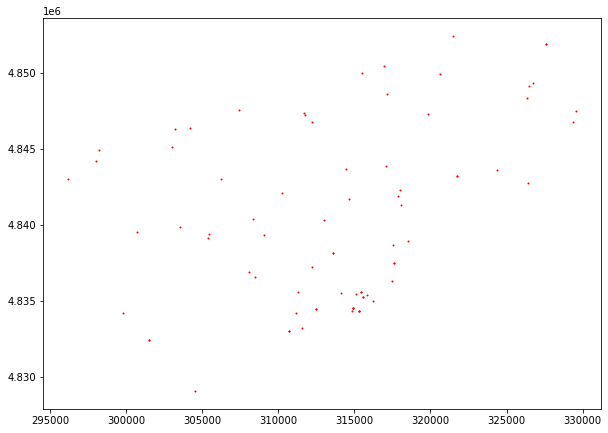

In [21]:
ax = AEU_dataset.plot(figsize=(10, 10),color='red', markersize =1)

### Read Pedestrian Network Data

In [22]:
# reading pednet file
pednet = gpd.read_file("pednet.zip")
pednet



,OBJECTID,road_type,sdwlk_code,sdwlk_desc,crosswalk,cwalk_type,px,px_type,length,geometry
0,1,Local,7.0,Sidewalk on both sides,0,None,None,None,93.867680,"LINESTRING (-79.56395 43.73781, -79.56292 43.7..."
1,2,Collector,7.0,Sidewalk on both sides,0,None,None,None,32.546284,"LINESTRING (-79.56791 43.63617, -79.56751 43.6..."
2,3,None,2.0,Sidewalk on north side only,0,None,None,None,117.669206,"LINESTRING (-79.37790 43.67845, -79.37651 43.6..."
3,4,None,7.0,Sidewalk on both sides,0,None,None,None,223.269710,"LINESTRING (-79.51851 43.70501, -79.51673 43.7..."
4,5,Local,7.0,Sidewalk on both sides,0,None,None,None,201.335648,"LINESTRING (-79.30121 43.77483, -79.29879 43.7..."
...,...,...,...,...,...,...,...,...,...,...
87100,87101,Walkway,11.0,City walkway,1,ts,1430,ts,32.249129,"LINESTRING (-79.57839 43.73537, -79.57802 43.7..."
87101,87102,Walkway,11.0,City walkway,1,ts,1174,ts,26.786411,"LINESTRING (-79.57049 43.71928, -79.57018 43.7..."
87102,87103,Walkway,11.0,City walkway,1,ts,888,ts,32.846849,"LINESTRING (-79.56001 43.69688, -79.55963 43.6..."
87103,87104,Walkway,11.0,City walkway,1,ts,2137,ts,30.031629,"LINESTRING (-79.57362 43.72571, -79.57326 43.7..."


In [ ]:
#AEU_dataset.head()

In [23]:
pednet.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
# reprojecting epsg 4326 (wgs84) to epsg 2019 (mtm nad 27)
pednet = pednet.to_crs({'init': 'epsg:2019'})
pednet.crs

C:\Users\aedge\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<Derived Projected CRS: EPSG:2019>
Name: NAD27(76) / MTM zone 10
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - Ontario - between 81°W and 78°W: south of 46°N in area to west of 80°15'W, south of 47°N in area between 80°15'W and 79°30'W, entire province between 79°30'W and 78°W.
- bounds: (-81.0, 42.26, -77.99, 47.33)
Coordinate Operation:
- name: MTM zone 10
- method: Transverse Mercator
Datum: North American Datum 1927 (1976)
- Ellipsoid: Clarke 1866
- Prime Meridian: Greenwich

In [ ]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
#crs = {'init': 'epsg:4326'}
#pednet = gpd.GeoDataFrame(pednet, crs=crs, geometry='geometry')
#pednet = pednet.to_crs({'init': 'epsg:2019'})

In [25]:
pednet.head()

,OBJECTID,road_type,sdwlk_code,sdwlk_desc,crosswalk,cwalk_type,px,px_type,length,geometry
0,1,Local,7.0,Sidewalk on both sides,0,None,None,None,93.867680,"LINESTRING (299648.279 4843992.545, 299731.442..."
1,2,Collector,7.0,Sidewalk on both sides,0,None,None,None,32.546284,"LINESTRING (299320.274 4832700.973, 299352.702..."
2,3,None,2.0,Sidewalk on north side only,0,None,None,None,117.669206,"LINESTRING (314645.043 4837402.435, 314757.047..."
3,4,None,7.0,Sidewalk on both sides,0,None,None,None,223.269710,"LINESTRING (303308.134 4840346.246, 303451.692..."
4,5,Local,7.0,Sidewalk on both sides,0,None,None,None,201.335648,"LINESTRING (320803.279 4848122.129, 320997.724..."


In [26]:
pednet.columns

Index(['OBJECTID', 'road_type', 'sdwlk_code', 'sdwlk_desc', 'crosswalk',
       'cwalk_type', 'px', 'px_type', 'length', 'geometry'],
      dtype='object')

<AxesSubplot:title={'center':'Pednet Road Type Distribution'}, xlabel='Road Types ', ylabel='Number'>

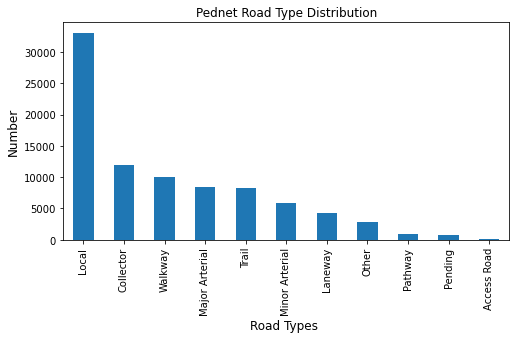

In [27]:
# distribution of road types in pednet

#plot
plt.figure(figsize=(8,4))
#ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Pednet Road Type Distribution")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Road Types ', fontsize=12)

pednet.road_type.value_counts().plot.bar()

## Create a plot of the city wide Pedestrian Network

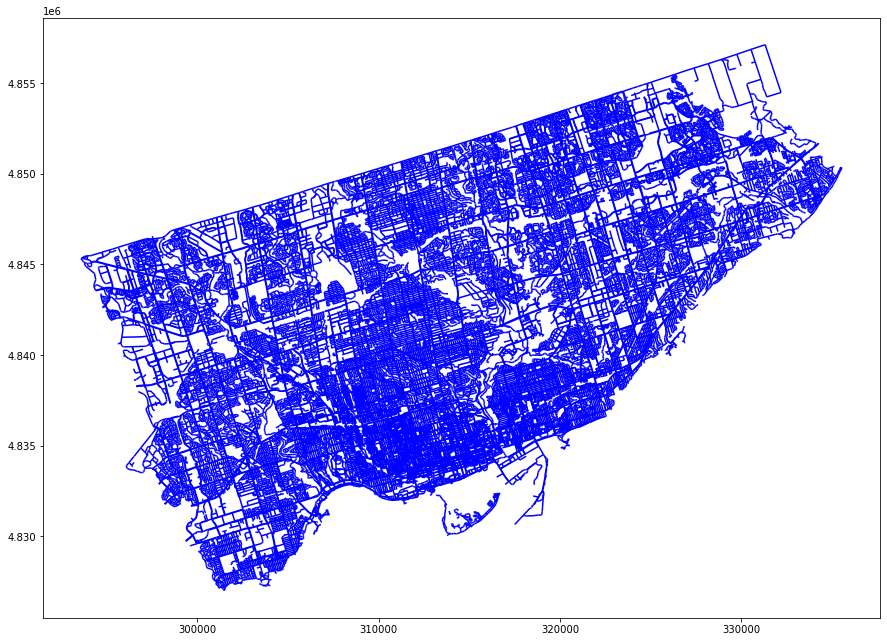

In [28]:
# plotting pednet layer
ax = pednet.plot(figsize=(15, 15),color='blue', markersize =1)

## Create a plot showing the Pedestrian Network at the city block level

In the plot below we see the cases where sidewalks are on both sides of the streets. Single lines represent several different features including local roads, walkways, laneways or private roads.

[(311000.0, 312000.0), (4834000.0, 4835000.0)]

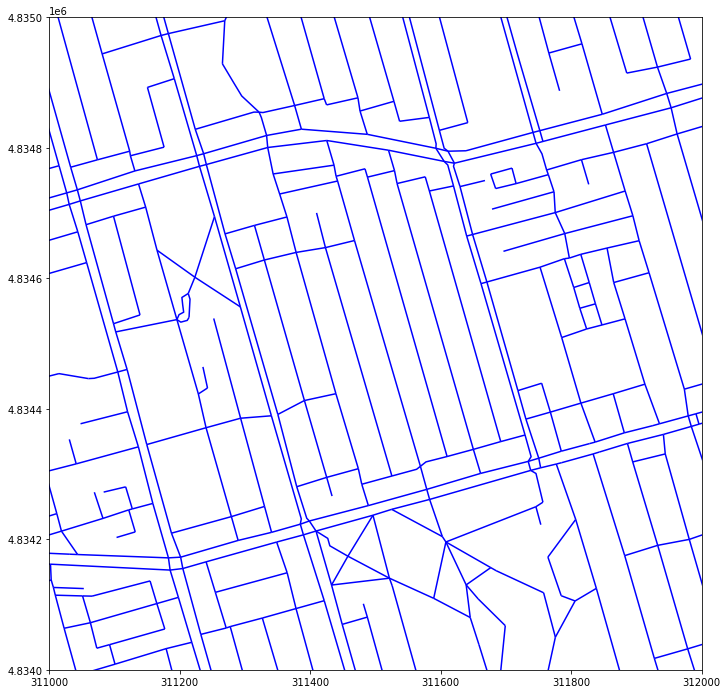

In [29]:
# plotting pednet layer with limits set
ax = pednet.plot(figsize=(12, 12),color='blue', markersize =1)
ax.set(xlim=(311000, 312000), ylim=(4834000, 4835000))

### Load Address Data
#### Read the Address point shape file and reproject to EPSG 2019

In [30]:
# reading municipal address point shape file
# https://open.toronto.ca/dataset/address-points-municipal-toronto-one-address-repository/
# Go to Download Data
address = gpd.read_file("municipal-address-points-wgs84-latitude-longitude.zip")
address

,GEO_ID,LINK,MAINT_STAG,ADDRESS,LFNAME,LONUM,LONUMSUF,HINUM,HINUMSUF,ARC_SIDE,...,CLASS,NAME,X,Y,LONGITUDE,LATITUDE,OBJECTID,MUN_NAME,WARD_NAME,geometry
0,1015200,914764,REGULAR,22,Lloyd George Ave,22,None,0,None,L,...,Land,None,301211.152,4827985.051,-79.544251,43.593789,4104309.0,Etobicoke,Etobicoke-Lakeshore,POINT (-79.54425 43.59379)
1,1015189,914764,REGULAR,3,Lloyd George Ave,3,None,0,None,R,...,Land,None,301272.174,4827946.759,-79.543495,43.593445,4104306.0,Etobicoke,Etobicoke-Lakeshore,POINT (-79.54350 43.59344)
2,20140046,914764,REGULAR,7A,Lloyd George Ave,7,A,0,None,R,...,Land,None,301265.553,4827966.490,-79.543577,43.593622,4104315.0,Etobicoke,Etobicoke-Lakeshore,POINT (-79.54358 43.59362)
3,1001594,914677,REGULAR,58,Foch Ave,58,None,0,None,L,...,Land,None,301024.624,4828252.320,-79.546567,43.596203,2842769.0,Etobicoke,Etobicoke-Lakeshore,POINT (-79.54657 43.59620)
4,1001593,914677,REGULAR,54,Foch Ave,54,None,0,None,L,...,Land,None,301037.208,4828229.086,-79.546411,43.595994,2005187.0,Etobicoke,Etobicoke-Lakeshore,POINT (-79.54641 43.59599)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525540,14204969,30113710,REGULAR,516,Symington Ave,516,None,0,None,L,...,Structure Entrance,None,308515.280,4836602.390,-79.453731,43.671356,4327937.0,former Toronto,Davenport,POINT (-79.45373 43.67136)
525541,30113757,30058626,RESERVED,4640,Eglinton Ave W,4640,None,0,None,R,...,Structure,None,300973.398,4837458.053,-79.547262,43.679057,4328455.0,Etobicoke,Etobicoke Centre,POINT (-79.54726 43.67906)
525542,30113756,30058626,RESERVED,4634,Eglinton Ave W,4634,None,0,None,R,...,Structure,None,301033.874,4837408.175,-79.546512,43.678608,4328456.0,Etobicoke,Etobicoke Centre,POINT (-79.54651 43.67861)
525543,30113758,30058626,RESERVED,4638,Eglinton Ave W,4638,None,0,None,R,...,Structure,None,300966.026,4837490.537,-79.547354,43.679349,4328458.0,Etobicoke,Etobicoke Centre,POINT (-79.54735 43.67935)


In [31]:
# change column names from upper to lower case
address.columns = map(str.lower, address.columns)

#include columns needed for the project
address = address[['geo_id', 'maint_stag','address','lfname','x','y','longitude','latitude','objectid','mun_name','ward_name','geometry']]
address

,geo_id,maint_stag,address,lfname,x,y,longitude,latitude,objectid,mun_name,ward_name,geometry
0,1015200,REGULAR,22,Lloyd George Ave,301211.152,4827985.051,-79.544251,43.593789,4104309.0,Etobicoke,Etobicoke-Lakeshore,POINT (-79.54425 43.59379)
1,1015189,REGULAR,3,Lloyd George Ave,301272.174,4827946.759,-79.543495,43.593445,4104306.0,Etobicoke,Etobicoke-Lakeshore,POINT (-79.54350 43.59344)
2,20140046,REGULAR,7A,Lloyd George Ave,301265.553,4827966.490,-79.543577,43.593622,4104315.0,Etobicoke,Etobicoke-Lakeshore,POINT (-79.54358 43.59362)
3,1001594,REGULAR,58,Foch Ave,301024.624,4828252.320,-79.546567,43.596203,2842769.0,Etobicoke,Etobicoke-Lakeshore,POINT (-79.54657 43.59620)
4,1001593,REGULAR,54,Foch Ave,301037.208,4828229.086,-79.546411,43.595994,2005187.0,Etobicoke,Etobicoke-Lakeshore,POINT (-79.54641 43.59599)
...,...,...,...,...,...,...,...,...,...,...,...,...
525540,14204969,REGULAR,516,Symington Ave,308515.280,4836602.390,-79.453731,43.671356,4327937.0,former Toronto,Davenport,POINT (-79.45373 43.67136)
525541,30113757,RESERVED,4640,Eglinton Ave W,300973.398,4837458.053,-79.547262,43.679057,4328455.0,Etobicoke,Etobicoke Centre,POINT (-79.54726 43.67906)
525542,30113756,RESERVED,4634,Eglinton Ave W,301033.874,4837408.175,-79.546512,43.678608,4328456.0,Etobicoke,Etobicoke Centre,POINT (-79.54651 43.67861)
525543,30113758,RESERVED,4638,Eglinton Ave W,300966.026,4837490.537,-79.547354,43.679349,4328458.0,Etobicoke,Etobicoke Centre,POINT (-79.54735 43.67935)


In [32]:
address.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [33]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
address = address.to_crs({'init': 'epsg:2019'})

C:\Users\aedge\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [ ]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
#crs = {'init': 'epsg:4326'}
#address = gpd.GeoDataFrame(address, crs=crs, geometry='geometry')
#address = address.to_crs({'init': 'epsg:2019'})

### Explore address point data

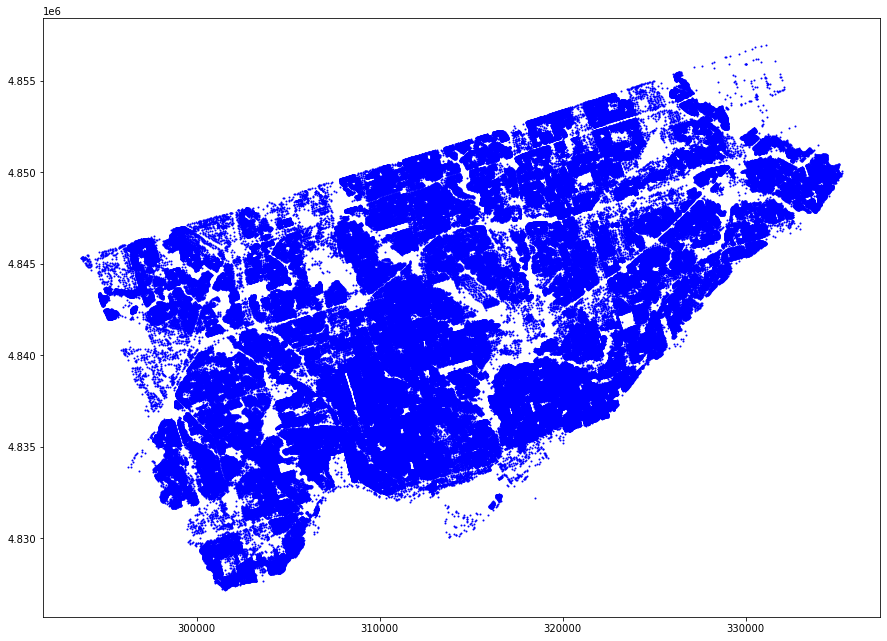

In [34]:
ax = address.plot(figsize=(15, 15),color='blue', markersize =1)

### Create a plot showing the address point data at the city block level


[(311200.0, 311800.0), (4834200.0, 4834800.0)]

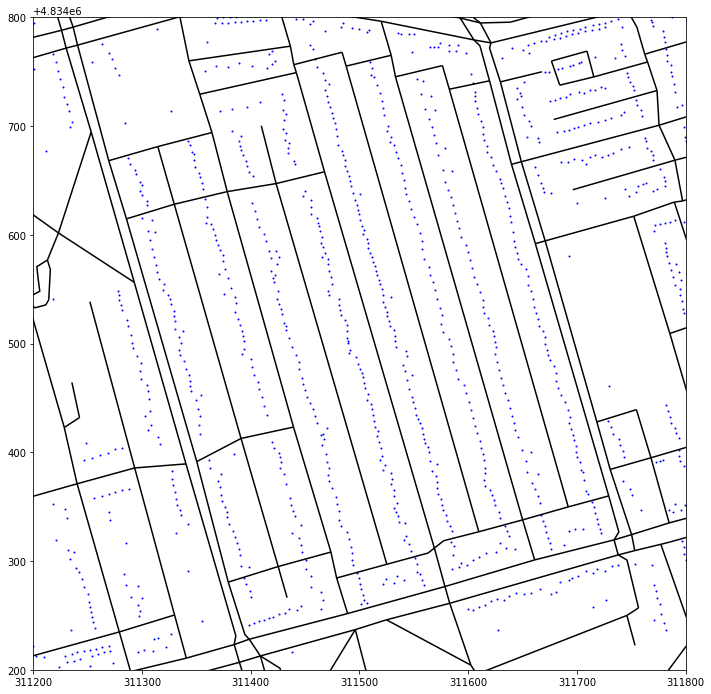

In [35]:
# plotting address layer with limits set
ax = address.plot(figsize=(12, 12),color='blue', markersize =1)
pednet.plot(ax=ax,color='black', markersize =2)
ax.set(xlim=(311200, 311800), ylim=(4834200, 4834800))

### Neighbourhood Improvement Areas
Read the Neighbourhood Improvement Areas polygon shape file and reproject to EPSG 2019

In [36]:
# reading Neighbourhood Improvement Areas polygon shape file
# https://open.toronto.ca/dataset/neighbourhood-improvement-areas/
# Go to Download Data
nia = gpd.read_file("neighbourhood-improvement-areas-wgs84.zip")
nia

,AREA_ID,DATE_EFF,DATE_EXP,AREA_AT_ID,AREA_TP_ID,PARNT_AREA,AREA_TYPE,AREA_CL_ID,AREA_CL,AREA_S_CD,...,FEAT_CD,FEAT_C_DSC,TR_ID_CRT,TR_ID_EXP,X,Y,LONGITUDE,LATITUDE,OBJECTID,geometry
0,25886593,2014-05-12,3000-01-01,25926665,602,49885,CNBH,0,None,027,...,0,None,105211,-1,305679.417,4847086.588,-79.488883,43.765736,16491553.0,"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."
1,25886723,2014-05-12,3000-01-01,25926718,602,49885,CNBH,0,None,003,...,0,None,105211,-1,299670.030,4844005.846,-79.563491,43.737988,16492401.0,"POLYGON ((-79.57751 43.73384, -79.57806 43.734..."
2,25886334,2014-05-12,3000-01-01,25926719,602,49885,CNBH,0,None,055,...,0,None,105211,-1,316874.178,4840655.317,-79.349984,43.707749,16492417.0,"POLYGON ((-79.33542 43.70320, -79.33573 43.703..."
3,25886704,2014-05-12,3000-01-01,25926708,602,49885,CNBH,0,None,028,...,0,None,105211,-1,304938.033,4841073.295,-79.498091,43.711609,16492241.0,"POLYGON ((-79.50384 43.70288, -79.50425 43.704..."
4,25886515,2014-05-12,3000-01-01,25926709,602,49885,CNBH,0,None,139,...,0,None,105211,-1,327594.737,4844116.308,-79.216813,43.738652,16492257.0,"POLYGON ((-79.21397 43.72676, -79.21400 43.726..."
5,25886994,2014-05-12,3000-01-01,25926710,602,49885,CNBH,0,None,085,...,0,None,105211,-1,309678.766,4832752.918,-79.439338,43.636700,16492273.0,"POLYGON ((-79.42778 43.62979, -79.42948 43.630..."
6,25886342,2014-05-12,3000-01-01,25926716,602,49885,CNBH,0,None,061,...,0,None,105211,-1,321236.202,4839247.968,-79.295901,43.694998,16492369.0,"POLYGON ((-79.28776 43.68978, -79.29269 43.688..."
7,25886613,2014-05-12,3000-01-01,25926790,602,49885,CNBH,0,None,021,...,0,None,105211,-1,300261.014,4846330.825,-79.556175,43.758920,16493553.0,"POLYGON ((-79.58064 43.76302, -79.57754 43.763..."
8,25886658,2014-05-12,3000-01-01,25926791,602,49885,CNBH,0,None,022,...,0,None,105211,-1,301371.929,4844609.257,-79.542367,43.743430,16493569.0,"POLYGON ((-79.52628 43.73640, -79.52649 43.736..."
9,25886693,2014-05-12,3000-01-01,25926778,602,49885,CNBH,0,None,044,...,0,None,105211,-1,318269.615,4841566.821,-79.332646,43.715930,16493361.0,"POLYGON ((-79.33791 43.70770, -79.33788 43.707..."


In [37]:
# change column names from upper to lower case
nia.columns = map(str.lower, nia.columns)

#include columns needed for the project
nia = nia[['area_id','area_s_cd','area_name','geometry']]
nia.head()

,area_id,area_s_cd,area_name,geometry
0,25886593,027,York University Heights (27),"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."
1,25886723,003,Thistletown-Beaumond Heights (3),"POLYGON ((-79.57751 43.73384, -79.57806 43.734..."
2,25886334,055,Thorncliffe Park (55),"POLYGON ((-79.33542 43.70320, -79.33573 43.703..."
3,25886704,028,Rustic (28),"POLYGON ((-79.50384 43.70288, -79.50425 43.704..."
4,25886515,139,Scarborough Village (139),"POLYGON ((-79.21397 43.72676, -79.21400 43.726..."


In [38]:
nia.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [39]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
#crs = {'init': 'epsg:4326'}
#nia = gpd.GeoDataFrame(nia, crs=crs, geometry='geometry')
nia = nia.to_crs({'init': 'epsg:2019'})

C:\Users\aedge\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## Explore Neighborhood Improvement Areas

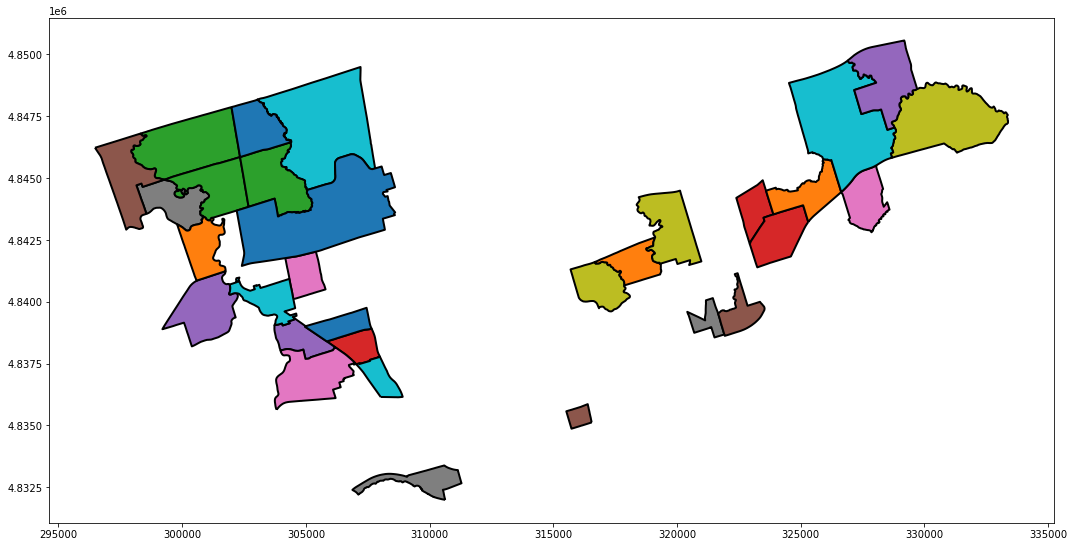

In [40]:
# plot Neighbourhood Improvement Areas
ax = nia.plot(figsize=(18, 13), column='area_name',edgecolor='black', linewidth=2)

### Step 2: Build Pandana Network
Pandana is a Python package that uses contraction hierarchies to perform rapid network calculations including shortest paths and accessibility buffers.

The link provides an introduction to the Pandana Network (https://udst.github.io/pandana/introduction.html).

### Create Network Graph Code Function

In [41]:
# creating network graph code
def create_graph(gdf, precision=3):
    '''Create a networkx given a GeoDataFrame of lines. Every line will
    correspond to two directional graph edges, one forward, one reverse. The
    original line row and direction will be stored in each edge. Every node
    will be where endpoints meet (determined by being very close together) and
    will store a clockwise ordering of incoming edges.
    '''
      
    G = nx.Graph()

    def make_node(coord, precision):
        return tuple(np.round(coord, precision))

    # Edges are stored as (from, to, data), where from and to are nodes.
    def add_edges(row, G):
        geometry = row.geometry
        coords = list(geometry.coords)
        geom_r = LineString(coords[::-1])
        coords_r = geom_r.coords
        start = make_node(coords[0], precision)
        end = make_node(coords[-1], precision)
        # Add forward edge
        fwd_attr ={}
        for k,v in row.items():
            fwd_attr[k]=v
        fwd_attr['forward']= 1
       #fwd_attr['geometry']=  geometry
        fwd_attr['length']=  geometry.length

        fwd_attr['visited']= 0

        G.add_edge(start, end, **fwd_attr)

    gdf.apply(add_edges, axis=1, args=[G])

    return G

### Create a graph network from the function above

In [42]:
# creating network graph
G = create_graph(pednet)
#from G to urbanaccess network model - one node idx,x,y one edge from to weight
#G.edges(data=True)

In [43]:
# get network "from" and "to" from nodes
edges = nx.to_pandas_edgelist(G,'from','to')
to = edges['to'].tolist()
fr = edges['from'].tolist()
fr = list(set(fr))
to = list(set(to))
to.extend(fr)
nodes = list(set(to))
nodes = pd.DataFrame(nodes)
nodes.columns=['x', 'y']
nodes['xy'] = nodes.apply(lambda z: (z.x,z.y),axis=1)

C:\Users\aedge\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


In [44]:
# Assigning node ids to to_node and from_node

nodes['id'] = nodes.index
edges['to_node']=edges['to'].map(nodes.set_index('xy').id)
edges['from_node']=edges['from'].map(nodes.set_index('xy').id)
edges

,from,to,px_type,forward,OBJECTID,cwalk_type,road_type,geometry,crosswalk,px,length,visited,sdwlk_desc,sdwlk_code,to_node,from_node
0,"(299648.279, 4843992.545)","(299731.442, 4843949.007)",None,1,1,None,Local,LINESTRING (299648.2789610377 4843992.54504902...,0,None,93.870579,0,Sidewalk on both sides,7.0,15164,34086
1,"(299648.279, 4843992.545)","(299603.437, 4844062.355)",None,1,84099,None,Local,LINESTRING (299603.43722473504 4844062.3551963...,0,None,82.971308,0,Sidewalk on both sides,7.0,44857,34086
2,"(299731.442, 4843949.007)","(299812.731, 4843907.011)",None,1,25712,None,Local,LINESTRING (299731.44201389625 4843949.0066491...,0,None,91.495742,0,No sidewalk on either side,3.0,18698,15164
3,"(299731.442, 4843949.007)","(299784.323, 4844032.478)",None,1,41588,None,Local,LINESTRING (299731.44201389625 4843949.0066491...,0,None,98.812729,0,Sidewalk on both sides,7.0,6442,15164
4,"(299320.274, 4832700.973)","(299352.702, 4832698.188)",None,1,2,None,Collector,LINESTRING (299320.2737241704 4832700.97291334...,0,None,32.547539,0,Sidewalk on both sides,7.0,11865,6965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87091,"(327230.47, 4852965.388)","(327238.397, 4853014.78)",None,1,85094,None,Minor Arterial,LINESTRING (327230.46994034346 4852965.3877477...,0,None,50.024218,0,Sidewalk on both sides,7.0,29687,331
87092,"(307052.373, 4834710.747)","(307057.304, 4834693.637)",None,1,85151,None,Local,LINESTRING (307052.3729006865 4834710.74710327...,0,None,17.806063,0,Sidewalk on both sides,7.0,14880,19139
87093,"(309342.861, 4837278.333)","(309285.428, 4837259.868)",None,1,86872,None,Laneway,LINESTRING (309285.42757424584 4837259.8680770...,0,None,60.328994,0,Laneway without any sidewalks,10.0,41211,60311
87094,"(321402.343, 4836954.005)","(321450.658, 4836948.849)",None,1,86895,None,Laneway,LINESTRING (321402.3429520032 4836954.00543335...,0,None,48.589315,0,Laneway without any sidewalks,10.0,63132,45558


### Creating and Saving Pandana Network
#### Create the Pandana Network and save the file in case you lose the network in memory

In [45]:
# creating pandana network

transit_ped_net = pdna.Network(nodes["x"],
                               nodes["y"],
                               edges["from_node"],
                               edges["to_node"],
                               pd.DataFrame([edges['length']]).T,
                               twoway=True)

# saving walkability file is optional. It can be used in the next steps if you don't have transit_ped_net in memory
#transit_ped_net.save_hdf5('./walkability.hd5')

### Precompute a Horizon Distance
It’s probably a good idea to precompute a given horizon distance so that aggregations don’t perform the network queries unnecessarily. This is done by calling the following code, where 1000 meters is used as the horizon distance:

In [46]:
transit_ped_net.precompute(1000)
transit_ped_net.edges_df

,from,to,length
0,34086,15164,93.870579
1,34086,44857,82.971308
2,15164,18698,91.495742
3,15164,6442,98.812729
4,6965,11865,32.547539
...,...,...,...
87091,331,29687,50.024218
87092,19139,14880,17.806063
87093,60311,41211,60.328994
87094,45558,63132,48.589315


In [47]:
#get node_ids for points for each layer
x, y = AEU_dataset.x, AEU_dataset.y
AEU_dataset["node_ids"] = transit_ped_net.get_node_ids(x, y)
transit_ped_net.set(AEU_dataset["node_ids"], name="AEU_dataset")

# using x and y coordinates from address that are utm nad27 
x, y = address.x, address.y
address["node_ids"] = transit_ped_net.get_node_ids(x, y)

In [48]:
AEU_dataset.node_ids

0     63658
1      3902
2     45502
3     26069
4      7064
      ...  
73    14695
74    25770
75    56546
76     8135
77    33825
Name: node_ids, Length: 78, dtype: int64

### Get 10 nearest AEU points
#### The 10 nearest AEUs will be determined.

In [49]:
#get nearest points with id
n=10
maxdistance = 5000

transit_ped_net.set_pois("AEU_dataset", maxdistance , n, AEU_dataset.x, AEU_dataset.y)
AEU_dataset_walk_distances = transit_ped_net.nearest_pois(maxdistance , "AEU_dataset", num_pois=n, include_poi_ids=False)

AEU_dataset_walk_distances

,1,2,3,4,5,6,7,8,9,10
0,3489.854980,3956.616943,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
1,2006.605957,2441.124023,2486.705078,2801.256104,2801.256104,2891.601074,3423.364990,3516.727051,3770.793945,3770.793945
2,3378.343994,3378.343994,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
3,1583.046021,1960.697021,3985.797119,4607.981934,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
4,550.575989,1694.536011,3200.876953,3865.278076,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
...,...,...,...,...,...,...,...,...,...,...
64710,894.252991,1620.011963,3508.270020,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
64711,4571.150879,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
64712,2173.041992,3083.730957,3084.386963,3713.750000,3768.126953,4256.255859,4760.931152,5000.000000,5000.000000,5000.000000
64713,2504.287109,4013.881104,4671.191895,4786.159180,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000


### Renaming columns

In [56]:
# Rename columns 1 to 10 to d_ttcstop_0 to d_ttcstop_9.

n=10

columns =  ['d_ttcstop_'+str(i) for i in range(0,n,1)]

AEU_dataset_walk_distances.columns = columns
AEU_dataset_walk_distances

,d_ttcstop_0,d_ttcstop_1,d_ttcstop_2,d_ttcstop_3,d_ttcstop_4,d_ttcstop_5,d_ttcstop_6,d_ttcstop_7,d_ttcstop_8,d_ttcstop_9
0,3489.854980,3956.616943,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
1,2006.605957,2441.124023,2486.705078,2801.256104,2801.256104,2891.601074,3423.364990,3516.727051,3770.793945,3770.793945
2,3378.343994,3378.343994,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
3,1583.046021,1960.697021,3985.797119,4607.981934,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
4,550.575989,1694.536011,3200.876953,3865.278076,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
...,...,...,...,...,...,...,...,...,...,...
64710,894.252991,1620.011963,3508.270020,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
64711,4571.150879,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
64712,2173.041992,3083.730957,3084.386963,3713.750000,3768.126953,4256.255859,4760.931152,5000.000000,5000.000000,5000.000000
64713,2504.287109,4013.881104,4671.191895,4786.159180,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000


### Calculating walk distance from address points to AEUs and get each point id from Adult Education Upgradings.

In [57]:
for i in range(10):
    address['d_ttcstop_{}'.format(i)]=address['node_ids'].map(AEU_dataset_walk_distances['d_ttcstop_{}'.format(i)])
address

,geo_id,maint_stag,address,lfname,x,y,longitude,latitude,objectid,mun_name,...,d_ttcstop_0,d_ttcstop_1,d_ttcstop_2,d_ttcstop_3,d_ttcstop_4,d_ttcstop_5,d_ttcstop_6,d_ttcstop_7,d_ttcstop_8,d_ttcstop_9
0,1015200,REGULAR,22,Lloyd George Ave,301211.152,4827985.051,-79.544251,43.593789,4104309.0,Etobicoke,...,4336.104980,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,5000.00000,5000.000000,5000.0
1,1015189,REGULAR,3,Lloyd George Ave,301272.174,4827946.759,-79.543495,43.593445,4104306.0,Etobicoke,...,4433.757812,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,5000.00000,5000.000000,5000.0
2,20140046,REGULAR,7A,Lloyd George Ave,301265.553,4827966.490,-79.543577,43.593622,4104315.0,Etobicoke,...,4433.757812,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,5000.00000,5000.000000,5000.0
3,1001594,REGULAR,58,Foch Ave,301024.624,4828252.320,-79.546567,43.596203,2842769.0,Etobicoke,...,4408.698242,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,5000.00000,5000.000000,5000.0
4,1001593,REGULAR,54,Foch Ave,301037.208,4828229.086,-79.546411,43.595994,2005187.0,Etobicoke,...,4408.698242,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,5000.00000,5000.000000,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525540,14204969,REGULAR,516,Symington Ave,308515.280,4836602.390,-79.453731,43.671356,4327937.0,former Toronto,...,468.558014,922.781006,3866.010986,3908.653076,4121.866211,4379.39502,4732.62793,4732.62793,4883.025879,5000.0
525541,30113757,RESERVED,4640,Eglinton Ave W,300973.398,4837458.053,-79.547262,43.679057,4328455.0,Etobicoke,...,2248.592041,4059.507080,4763.131836,5000.000000,5000.000000,5000.00000,5000.00000,5000.00000,5000.000000,5000.0
525542,30113756,RESERVED,4634,Eglinton Ave W,301033.874,4837408.175,-79.546512,43.678608,4328456.0,Etobicoke,...,2505.254883,4313.148926,4650.041992,5000.000000,5000.000000,5000.00000,5000.00000,5000.00000,5000.000000,5000.0
525543,30113758,RESERVED,4638,Eglinton Ave W,300966.026,4837490.537,-79.547354,43.679349,4328458.0,Etobicoke,...,2248.592041,4059.507080,4763.131836,5000.000000,5000.000000,5000.00000,5000.00000,5000.00000,5000.000000,5000.0


### Calculate minutes fields based on distances
#### We are applying an average pedestrian walking speed of 1.2 m/s which is used by the City of Toronto Transportation Services uses.The link below is to the TRANSPORTATION SERVICES STANDARD OPERATING PRACTICE - TRAFFIC SYSTEMS OPERATIONS document which discusses the standardized walk speed of 1.2 m/s.

https://www.toronto.ca/wp-content/uploads/2019/01/96a8-TS_Traffic-Management_Pedestrian-Timing-Guidelines.pdf

In [58]:
# Calculate minutes fields based on distances. This cell takes 1.5 minutes to run.

address['m_ttcstop_0'] = address.apply(lambda row: row.d_ttcstop_0/(1.2*60), axis=1)
address['m_ttcstop_1'] = address.apply(lambda row: row.d_ttcstop_1/(1.2*60), axis=1)
address['m_ttcstop_2'] = address.apply(lambda row: row.d_ttcstop_2/(1.2*60), axis=1)
address['m_ttcstop_3'] = address.apply(lambda row: row.d_ttcstop_3/(1.2*60), axis=1)
address['m_ttcstop_4'] = address.apply(lambda row: row.d_ttcstop_4/(1.2*60), axis=1)
address['m_ttcstop_5'] = address.apply(lambda row: row.d_ttcstop_5/(1.2*60), axis=1)
address['m_ttcstop_6'] = address.apply(lambda row: row.d_ttcstop_6/(1.2*60), axis=1)
address['m_ttcstop_7'] = address.apply(lambda row: row.d_ttcstop_7/(1.2*60), axis=1)
address['m_ttcstop_8'] = address.apply(lambda row: row.d_ttcstop_8/(1.2*60), axis=1)
address['m_ttcstop_9'] = address.apply(lambda row: row.d_ttcstop_9/(1.2*60), axis=1)
address

,geo_id,maint_stag,address,lfname,x,y,longitude,latitude,objectid,mun_name,...,m_ttcstop_0,m_ttcstop_1,m_ttcstop_2,m_ttcstop_3,m_ttcstop_4,m_ttcstop_5,m_ttcstop_6,m_ttcstop_7,m_ttcstop_8,m_ttcstop_9
0,1015200,REGULAR,22,Lloyd George Ave,301211.152,4827985.051,-79.544251,43.593789,4104309.0,Etobicoke,...,60.223680,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444
1,1015189,REGULAR,3,Lloyd George Ave,301272.174,4827946.759,-79.543495,43.593445,4104306.0,Etobicoke,...,61.579970,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444
2,20140046,REGULAR,7A,Lloyd George Ave,301265.553,4827966.490,-79.543577,43.593622,4104315.0,Etobicoke,...,61.579970,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444
3,1001594,REGULAR,58,Foch Ave,301024.624,4828252.320,-79.546567,43.596203,2842769.0,Etobicoke,...,61.231920,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444
4,1001593,REGULAR,54,Foch Ave,301037.208,4828229.086,-79.546411,43.595994,2005187.0,Etobicoke,...,61.231920,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525540,14204969,REGULAR,516,Symington Ave,308515.280,4836602.390,-79.453731,43.671356,4327937.0,former Toronto,...,6.507750,12.816403,53.694597,54.286848,57.248142,60.824931,65.730943,65.730943,67.819804,69.444444
525541,30113757,RESERVED,4640,Eglinton Ave W,300973.398,4837458.053,-79.547262,43.679057,4328455.0,Etobicoke,...,31.230445,56.382043,66.154609,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444
525542,30113756,RESERVED,4634,Eglinton Ave W,301033.874,4837408.175,-79.546512,43.678608,4328456.0,Etobicoke,...,34.795207,59.904846,64.583917,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444
525543,30113758,RESERVED,4638,Eglinton Ave W,300966.026,4837490.537,-79.547354,43.679349,4328458.0,Etobicoke,...,31.230445,56.382043,66.154609,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444


# Step 3: Visualize Walking Times
## In this step we will create a series of visulations illustrating the walking times to the nearest CCC across the pedestrian network.

### Walking Times To Closest AEU
In this section we will create a chloropleth map showing the walk times to the closest AEU across the City of Toronto. As expected the shortest walk times are along majorial aerterials where AEUs are located as shown in the second map below where the AEUs are colour coded red.

Text(0.5, 1.0, 'Walking Times To Closest AEU')

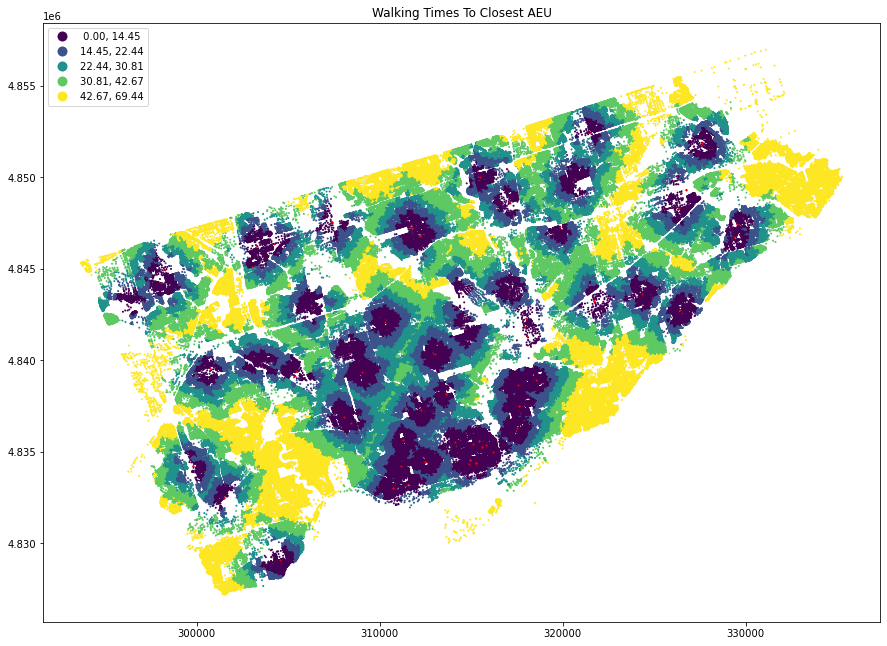

In [59]:
# Walking times To closest CCC with CCCs added
import mapclassify
ax = address.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
AEU_dataset.plot(ax=ax, color='red', markersize =1)
plt.title('Walking Times To Closest AEU')

## Walking Times To Closest AEU with Neighbourhood Improvement Areas
#### In this step we will invesitgate the walk times in the Neighbourhood Improvement Areas.

## Get the Neighbourhood Improvement Area centre points
#### To place a label on each Neighbourhood Improvement Areas in the plot we need to find an identifiable point which exists within each polygon so that we can say where we want the text to be placed.

In [60]:
# Here we find the center points, copy our original df to a new df, and then set
# the geometry column to the newly created center points column
# (because a GeoPandas df can only have one geometry column)
nia["center"] = nia["geometry"].centroid
nia_points = nia.copy()
nia_points.set_geometry("center", inplace = True)

Text(0.5, 1.0, 'Walking Times To Closest CCC \n within Neighbourhood Improvement Areas')

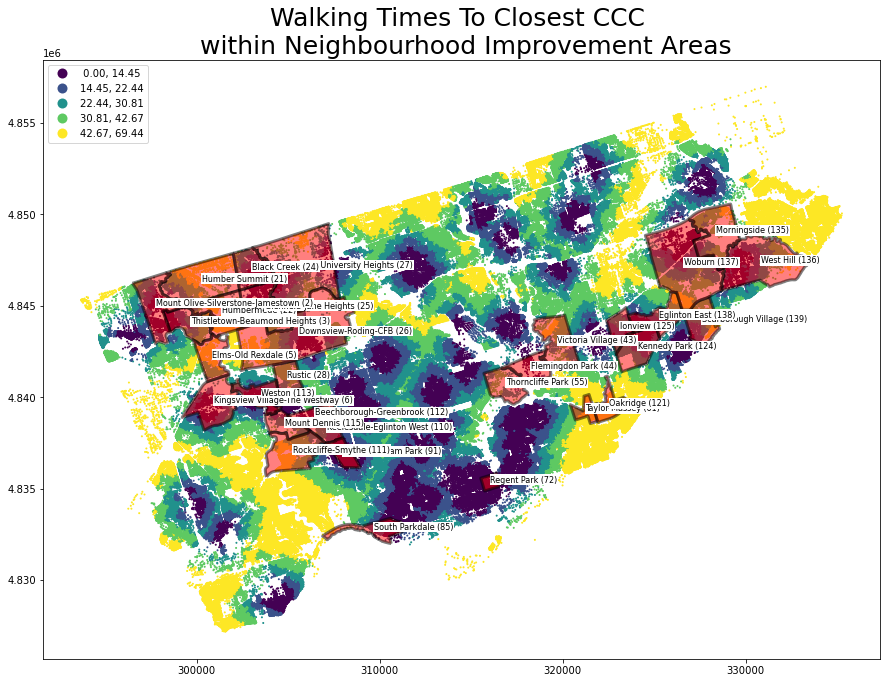

In [61]:
# ploting and adding labels for Neighbourhood Improvement Areas
ax = address.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
nia.plot(ax=ax, edgecolor='black', facecolor='red', linewidth=3, alpha=.5 )
texts = []

# Plot labels and add a white box behind the label using the matplotlib bbox class.
for x, y, label in zip(nia_points.geometry.x, nia_points.geometry.y, nia_points["area_name"]):
    texts.append(plt.text(x, y, label, fontsize = 8, bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none')))

ax.set_title('Walking Times To Closest AEUs \n within Neighbourhood Improvement Areas', fontdict={'fontsize': '25', 'fontweight' : '3'})

#plt.savefig("./walkability_nia.png", dpi=300)

# Addresses within Neighbourhood Improvement Areas
#### We will now perform a spatial join between Neighbourhood Improvement Area layer and address layer in order to allocate addresses to Neighbourhood Improvement Areas.

In [62]:
# Spatial Join where Neighbourhood Improvement Area polygons are intersected with address points
nia_address = gpd.sjoin(nia, address, op='intersects', how='left')
nia_address

C:\Users\aedge\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,area_id,area_s_cd,area_name,geometry,center,index_right,geo_id,maint_stag,address,lfname,...,m_ttcstop_0,m_ttcstop_1,m_ttcstop_2,m_ttcstop_3,m_ttcstop_4,m_ttcstop_5,m_ttcstop_6,m_ttcstop_7,m_ttcstop_8,m_ttcstop_9
0,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),235778,5479008,REGULAR,801,Alness St,...,18.810791,57.036641,68.121901,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444
0,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),235779,30073785,REGULAR,803,Alness St,...,18.810791,57.036641,68.121901,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444
0,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),235780,30073786,REGULAR,805,Alness St,...,18.810791,57.036641,68.121901,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444
0,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),236230,30073787,REGULAR,807,Alness St,...,18.810791,57.036641,68.121901,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444
0,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),236231,30073788,REGULAR,809,Alness St,...,18.810791,57.036641,68.121901,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,25886466,135,Morningside (135),"POLYGON ((326891.120 4849741.351, 326893.887 4...",POINT (328381.142 4848985.391),474693,353177,REGULAR,3,Ladysbridge Dr,...,19.843501,20.598736,42.903819,43.303972,55.109721,69.444444,69.444444,69.444444,69.444444,69.444444
30,25886466,135,Morningside (135),"POLYGON ((326891.120 4849741.351, 326893.887 4...",POINT (328381.142 4848985.391),474694,353179,REGULAR,5,Ladysbridge Dr,...,19.843501,20.598736,42.903819,43.303972,55.109721,69.444444,69.444444,69.444444,69.444444,69.444444
30,25886466,135,Morningside (135),"POLYGON ((326891.120 4849741.351, 326893.887 4...",POINT (328381.142 4848985.391),474784,353181,REGULAR,7,Ladysbridge Dr,...,21.163486,21.918722,44.223806,44.623959,56.429708,69.444444,69.444444,69.444444,69.444444,69.444444
30,25886466,135,Morningside (135),"POLYGON ((326891.120 4849741.351, 326893.887 4...",POINT (328381.142 4848985.391),474594,13366887,REGULAR,3950,Lawrence Ave E,...,17.336166,18.091404,44.302043,45.947486,56.107791,69.444444,69.444444,69.444444,69.444444,69.444444


## Count of addresses in Neighbourhood Improvement Areas
#### We will now do a count of addresses within each Neighbourhood Improvement Areas and visualize the results in a bar plot.

In [63]:
# count of addresses assigned to each Neighbourhood Improvement Area
value_counts = nia_address.area_name.value_counts()
value_counts

Woburn (137)                             8491
Downsview-Roding-CFB (26)                7742
West Hill (136)                          5353
Rockcliffe-Smythe (111)                  5161
Glenfield-Jane Heights (25)              4819
York University Heights (27)             4399
Humber Summit (21)                       3748
Weston-Pellam Park (91)                  3407
Keelesdale-Eglinton West (110)           3143
Kennedy Park (124)                       3046
Weston (113)                             3040
Morningside (135)                        2955
Kingsview Village-The Westway (6)        2804
Mount Olive-Silverstone-Jamestown (2)    2771
Humbermede (22)                          2632
Thistletown-Beaumond Heights (3)         2484
Eglinton East (138)                      2432
Victoria Village (43)                    2267
Oakridge (121)                           2162
Mount Dennis (115)                       1961
Black Creek (24)                         1947
Ionview (125)                     

In [64]:
# count of addresses assigned to each Neighbourhood Improvement Area
value_counts = nia_address.area_name.value_counts()
value_counts

# renaming axixs to area_name and resetting index to nia_address_count
nia_address_counts = value_counts.rename_axis('area_name').reset_index(name='nia_address_count')
nia_address_counts

# merge nia_address_counts with nia_address using the area_name which is shared by both dataframes
nia_address = pd.merge(nia_address, nia_address_counts)

nia_address

,area_id,area_s_cd,area_name,geometry,center,index_right,geo_id,maint_stag,address,lfname,...,m_ttcstop_1,m_ttcstop_2,m_ttcstop_3,m_ttcstop_4,m_ttcstop_5,m_ttcstop_6,m_ttcstop_7,m_ttcstop_8,m_ttcstop_9,nia_address_count
0,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),235778,5479008,REGULAR,801,Alness St,...,57.036641,68.121901,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,4399
1,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),235779,30073785,REGULAR,803,Alness St,...,57.036641,68.121901,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,4399
2,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),235780,30073786,REGULAR,805,Alness St,...,57.036641,68.121901,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,4399
3,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),236230,30073787,REGULAR,807,Alness St,...,57.036641,68.121901,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,4399
4,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),236231,30073788,REGULAR,809,Alness St,...,57.036641,68.121901,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,4399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89603,25886466,135,Morningside (135),"POLYGON ((326891.120 4849741.351, 326893.887 4...",POINT (328381.142 4848985.391),474693,353177,REGULAR,3,Ladysbridge Dr,...,20.598736,42.903819,43.303972,55.109721,69.444444,69.444444,69.444444,69.444444,69.444444,2955
89604,25886466,135,Morningside (135),"POLYGON ((326891.120 4849741.351, 326893.887 4...",POINT (328381.142 4848985.391),474694,353179,REGULAR,5,Ladysbridge Dr,...,20.598736,42.903819,43.303972,55.109721,69.444444,69.444444,69.444444,69.444444,69.444444,2955
89605,25886466,135,Morningside (135),"POLYGON ((326891.120 4849741.351, 326893.887 4...",POINT (328381.142 4848985.391),474784,353181,REGULAR,7,Ladysbridge Dr,...,21.918722,44.223806,44.623959,56.429708,69.444444,69.444444,69.444444,69.444444,69.444444,2955
89606,25886466,135,Morningside (135),"POLYGON ((326891.120 4849741.351, 326893.887 4...",POINT (328381.142 4848985.391),474594,13366887,REGULAR,3950,Lawrence Ave E,...,18.091404,44.302043,45.947486,56.107791,69.444444,69.444444,69.444444,69.444444,69.444444,2955


<AxesSubplot:title={'center':'Address Count in Neighbourhood Improvement Areas'}, xlabel='Neighbourhood Improvement Areas', ylabel='Number'>

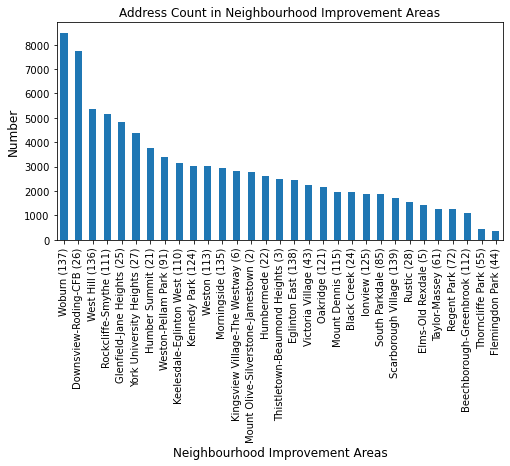

In [65]:
# distribution of addresses in nia_address

#plot
plt.figure(figsize=(8,4))

plt.title("Address Count in Neighbourhood Improvement Areas")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Neighbourhood Improvement Areas', fontsize=12)

nia_address.area_name.value_counts().plot.bar()

Text(0.5, 1.0, 'Walking Times To Closest AEU')

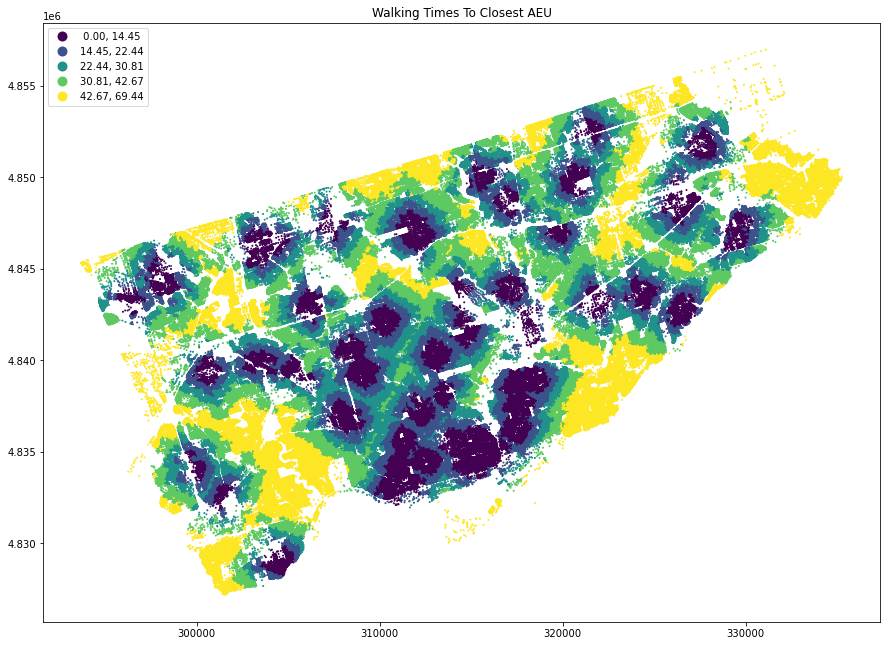

In [66]:
# Walking Times To Closest AEU
ax = address.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
plt.title('Walking Times To Closest AEU')

# Average Walking Times To Closest AEU in Neighbourhood Improvement Areas
#### We will now use the mean function to calculate the mean walking time to the closest AEU for each of the Neighbourhood Improvement Areas.

In [67]:
mins_avgs = nia_address.groupby('area_name')['m_ttcstop_0'].mean()
mins_avgs

area_name
Beechborough-Greenbrook (112)            22.768562
Black Creek (24)                         17.209224
Downsview-Roding-CFB (26)                27.729179
Eglinton East (138)                      21.815445
Elms-Old Rexdale (5)                     42.248425
Flemingdon Park (44)                      8.946988
Glenfield-Jane Heights (25)              24.479173
Humber Summit (21)                       37.711898
Humbermede (22)                          45.976817
Ionview (125)                            21.554000
Keelesdale-Eglinton West (110)           22.401842
Kennedy Park (124)                       18.108398
Kingsview Village-The Westway (6)        16.115891
Morningside (135)                        33.102785
Mount Dennis (115)                       25.439224
Mount Olive-Silverstone-Jamestown (2)    18.641502
Oakridge (121)                           58.708869
Regent Park (72)                          4.216571
Rockcliffe-Smythe (111)                  38.762820
Rustic (28)          

In [68]:
# renaming axixs to area_name and resetting index to nia_addr_avg_min
nia_addr_avg_min = mins_avgs.rename_axis('area_name').reset_index(name='nia_addr_avg_min')
nia_addr_avg_min

# merge nia_address with nia_addr_avg_min using area_name
nia_address = pd.merge(nia_address, nia_addr_avg_min)

nia_address

,area_id,area_s_cd,area_name,geometry,center,index_right,geo_id,maint_stag,address,lfname,...,m_ttcstop_2,m_ttcstop_3,m_ttcstop_4,m_ttcstop_5,m_ttcstop_6,m_ttcstop_7,m_ttcstop_8,m_ttcstop_9,nia_address_count,nia_addr_avg_min
0,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),235778,5479008,REGULAR,801,Alness St,...,68.121901,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,4399,24.447981
1,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),235779,30073785,REGULAR,803,Alness St,...,68.121901,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,4399,24.447981
2,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),235780,30073786,REGULAR,805,Alness St,...,68.121901,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,4399,24.447981
3,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),236230,30073787,REGULAR,807,Alness St,...,68.121901,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,4399,24.447981
4,25886593,027,York University Heights (27),"POLYGON ((304374.200 4846441.251, 304406.841 4...",POINT (305695.095 4847092.650),236231,30073788,REGULAR,809,Alness St,...,68.121901,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,69.444444,4399,24.447981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89603,25886466,135,Morningside (135),"POLYGON ((326891.120 4849741.351, 326893.887 4...",POINT (328381.142 4848985.391),474693,353177,REGULAR,3,Ladysbridge Dr,...,42.903819,43.303972,55.109721,69.444444,69.444444,69.444444,69.444444,69.444444,2955,33.102785
89604,25886466,135,Morningside (135),"POLYGON ((326891.120 4849741.351, 326893.887 4...",POINT (328381.142 4848985.391),474694,353179,REGULAR,5,Ladysbridge Dr,...,42.903819,43.303972,55.109721,69.444444,69.444444,69.444444,69.444444,69.444444,2955,33.102785
89605,25886466,135,Morningside (135),"POLYGON ((326891.120 4849741.351, 326893.887 4...",POINT (328381.142 4848985.391),474784,353181,REGULAR,7,Ladysbridge Dr,...,44.223806,44.623959,56.429708,69.444444,69.444444,69.444444,69.444444,69.444444,2955,33.102785
89606,25886466,135,Morningside (135),"POLYGON ((326891.120 4849741.351, 326893.887 4...",POINT (328381.142 4848985.391),474594,13366887,REGULAR,3950,Lawrence Ave E,...,44.302043,45.947486,56.107791,69.444444,69.444444,69.444444,69.444444,69.444444,2955,33.102785


<AxesSubplot:xlabel='area_name'>

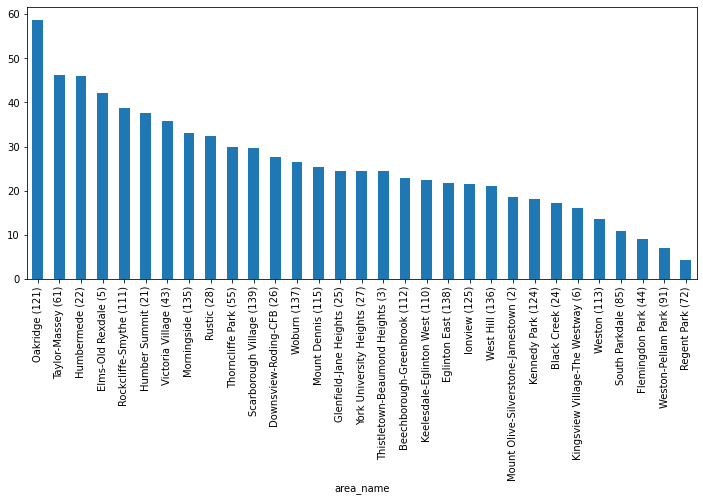

In [69]:
# plot bar plot
plt.figure(figsize=(12,5))
nia_address_bar = nia_address.groupby(['area_name'])['m_ttcstop_0'].mean()

nia_address_bar.sort_values(ascending=False).plot.bar()

# Plot Average Walking times to the Closest AEU for each Neighbourhood Improvement Area

Text(0.1, 0.08, 'Source: Toronto Open Data')

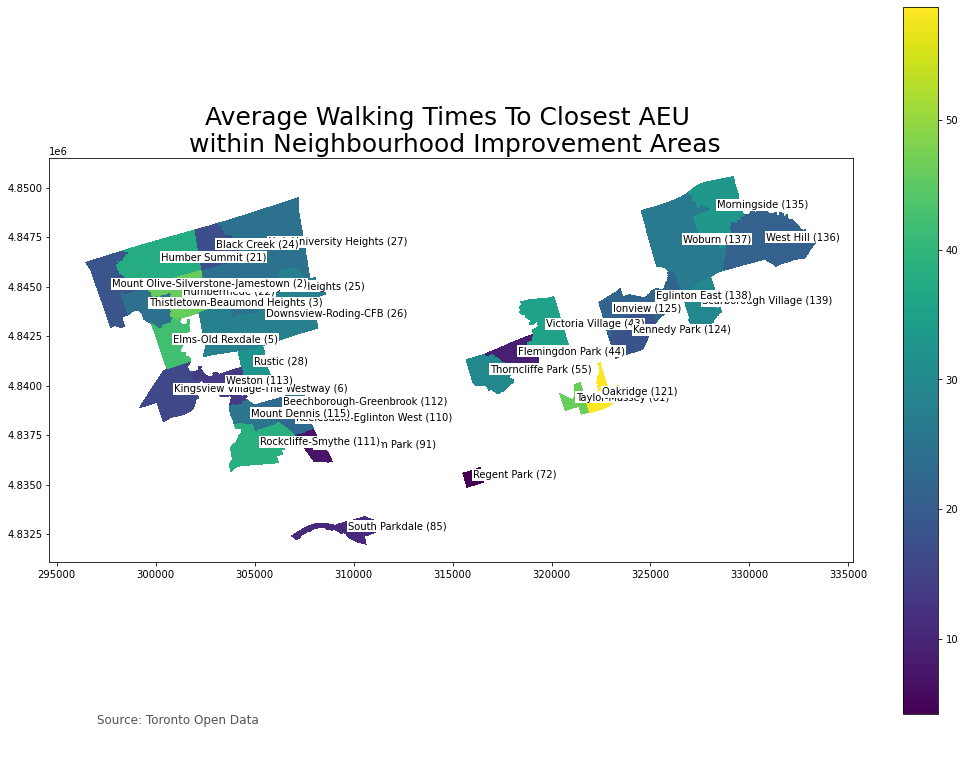

In [70]:
# plot Average Walking Times To Closest CCC in Neighbourhood Improvement Areas
ax = nia_address.plot(figsize=(18, 13), column='nia_addr_avg_min', legend=True)
ax.set_title('Average Walking Times To Closest AEU \n within Neighbourhood Improvement Areas', fontdict={'fontsize': '25', 'fontweight' : '3'})

# Plot labels and add a white box behind the label using the matplotlib bbox class.
for x, y, label in zip(nia_points.geometry.x, nia_points.geometry.y, nia_points["area_name"]):
    texts.append(plt.text(x, y, label, fontsize = 10, bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none')))
# create an annotation for the data source
ax.annotate('Source: Toronto Open Data',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

## Get bounds of each Neighbourhood Improvement Area polygon
#### We will list all of the Neighbourhood Improvement Areas. Select the index_left value corresponding to the Neighbourhood Improvement Area you want to display in the dataframe bell. We will use the bounding box function to obtain the polygon coordinates for each Neighbourhood Improvement Area. We will then use the bound box coordinates for a particular Neighbourhood Improvement Area polygon to show the walking times within the Neighbourhood Improvement Area.

In [71]:
# index_left and area_name
nia.area_name

0              York University Heights (27)
1          Thistletown-Beaumond Heights (3)
2                     Thorncliffe Park (55)
3                               Rustic (28)
4                 Scarborough Village (139)
5                       South Parkdale (85)
6                        Taylor-Massey (61)
7                        Humber Summit (21)
8                           Humbermede (22)
9                      Flemingdon Park (44)
10                            Ionview (125)
11              Glenfield-Jane Heights (25)
12                    Victoria Village (43)
13                          West Hill (136)
14                       Kennedy Park (124)
15        Kingsview Village-The Westway (6)
16           Keelesdale-Eglinton West (110)
17                       Mount Dennis (115)
18            Beechborough-Greenbrook (112)
19                           Oakridge (121)
20                      Eglinton East (138)
21                     Elms-Old Rexdale (5)
22                         Regen

In [72]:
# Get bounding box coordinates and area name for a particular Neighbourhood Improvement Area
# Pick index number from the list above and place it in the []
minx,miny,maxx,maxy = nia.bounds.iloc[4].values
# Pick the same index number from the list above and place it in the [] to get the area name
nia_area_name = nia.area_name.iloc[4]
nia_area_name

'Scarborough Village (139)'

# Plotting Neighbourhood Improvement Area using bounding box co-ordinates

Text(0.1, 0.05, 'Source: Toronto Open Data')

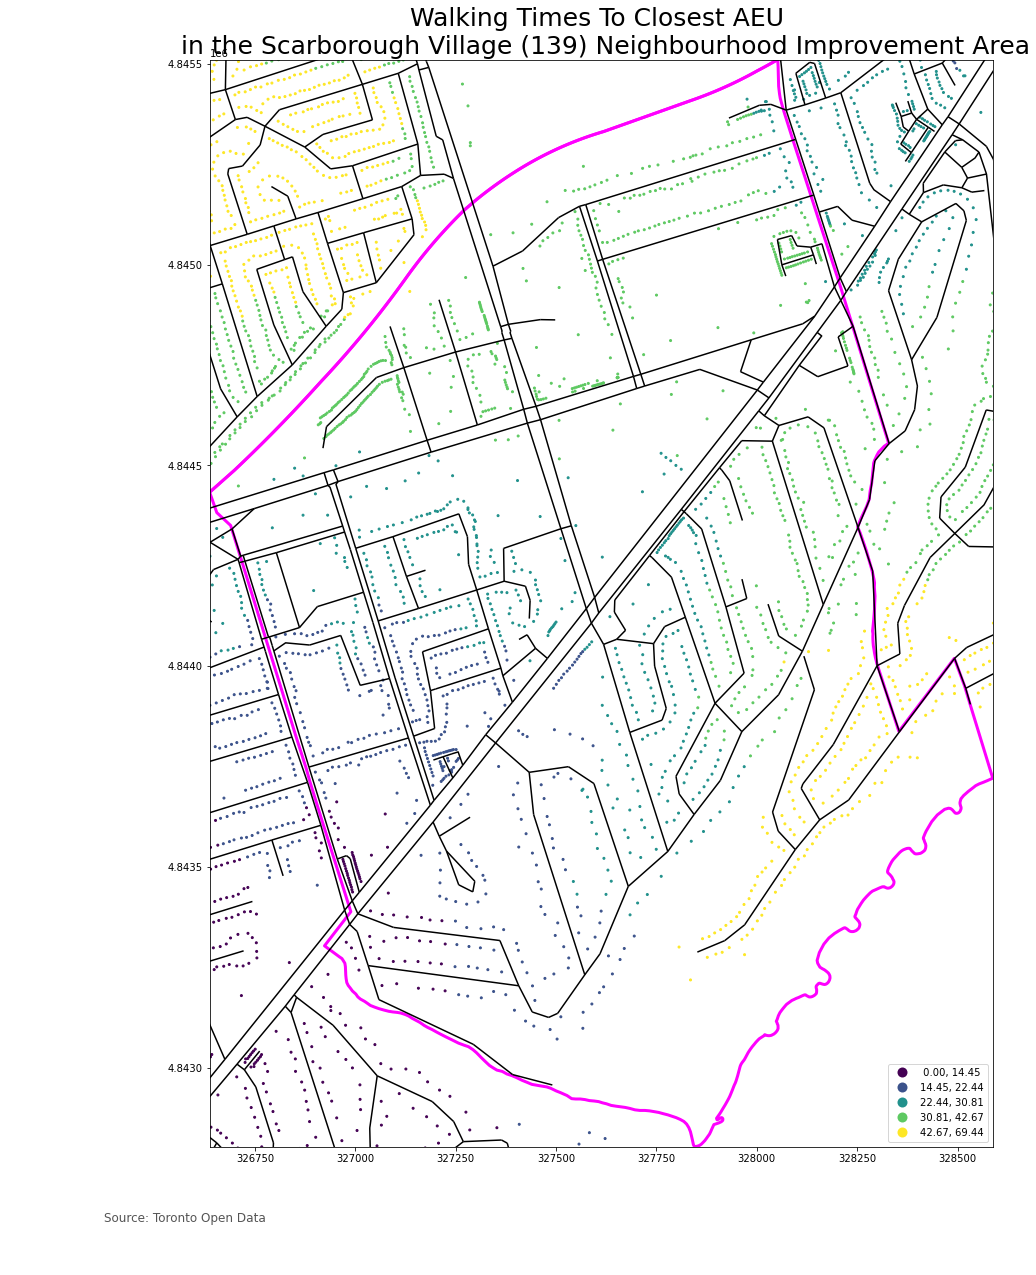

In [74]:
### plotting Neighbourhood Improvement Area using bounding box co-ordinates
#name = nia_area_name
ax = address.plot(figsize=(20, 20), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 4)
nia.plot(ax=ax, facecolor='none', edgecolor='magenta', linewidth=3)
AEU_dataset.plot(ax=ax, color='red', markersize =15)
pednet.plot(ax=ax,color='black', markersize =1)

# getting limits
ax.set(xlim=(minx, maxx), ylim=(miny, maxy))

# add a title
ax.set_title((('Walking Times To Closest AEU \n in the {0} Neighbourhood Improvement Area').format(nia_area_name)), fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: Toronto Open Data',xy=(0.1, .05),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

#option to save figure
#fig.savefig("./ccc_walkability.png", dpi=300)